# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **Data Loading and Preparation**

#### **Import Necessary Libraries**

In [12]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **1.1 Data Aggregation** 

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame.

In [8]:
# Define a function to load data and aggregate them

def combine_stock_data(file_list):
    combined_df = None
    
    for file in file_list:
        # Extract stock name from filename
        name = os.path.splitext(os.path.basename(file))[0]
        name = name.split('_')[0]
        
        # Read CSV into DataFrame
        df = pd.read_csv(file)
        
        # Ensure 'Date' is datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Drop unnecessary columns
        if 'Name' in df.columns:
            df.drop(columns=['Name'], inplace=True)
        
        # Rename columns (except 'Date')
        df = df.rename(columns={col: f'{name}_{col}' for col in df.columns if col != 'Date'})
        
        # Merge based on 'Date'
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on='Date', how='outer')
    
    # Sort by date
    combined_df.sort_values(by='Date', inplace=True)
    
    return combined_df


In [16]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

os.chdir('./RNN_Stocks_Data')

file_list = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'MSFT_stocks_data.csv', 'IBM_stocks_data.csv']
combined_df = combine_stock_data(file_list)


In [15]:
# View specifics of the data

display(combined_df.head())
combined_df.info()

,Date,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,...,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume
0,2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,...,26.25,27.00,26.10,26.84,79974418.0,82.45,82.55,80.81,82.06,11715200
1,2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,...,26.77,27.08,26.77,26.97,57975661.0,82.20,82.50,81.33,81.95,9840600
2,2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,...,26.96,27.13,26.91,26.99,48247610.0,81.40,82.90,81.00,82.50,7213500
3,2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,...,26.89,27.00,26.49,26.91,100969092.0,83.95,85.03,83.41,84.95,8197400
4,2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,...,26.93,27.07,26.76,26.86,55627836.0,84.10,84.25,83.38,83.73,6858200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3020 non-null   datetime64[ns]
 1   AMZN_Open     3019 non-null   float64       
 2   AMZN_High     3019 non-null   float64       
 3   AMZN_Low      3019 non-null   float64       
 4   AMZN_Close    3019 non-null   float64       
 5   AMZN_Volume   3019 non-null   float64       
 6   GOOGL_Open    3019 non-null   float64       
 7   GOOGL_High    3019 non-null   float64       
 8   GOOGL_Low     3019 non-null   float64       
 9   GOOGL_Close   3019 non-null   float64       
 10  GOOGL_Volume  3019 non-null   float64       
 11  MSFT_Open     3019 non-null   float64       
 12  MSFT_High     3019 non-null   float64       
 13  MSFT_Low      3019 non-null   float64       
 14  MSFT_Close    3019 non-null   float64       
 15  MSFT_Volume   3019 non-null   float64 

In [18]:
# Handle Missing Values


print(f'--Number of missing values--\n\n{combined_df.isna().sum()}')
combined_df.dropna(inplace= True)
print('\n------Missing Values Processed!!---------\n')
print(f'--Number of missing values--\n\n{combined_df.isna().sum()}')


--Number of missing values--

Date            0
AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
dtype: int64

------Missing Values Processed!!---------

--Number of missing values--

Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
dtype: int64


### **1.2 Analysis and Visualisation**

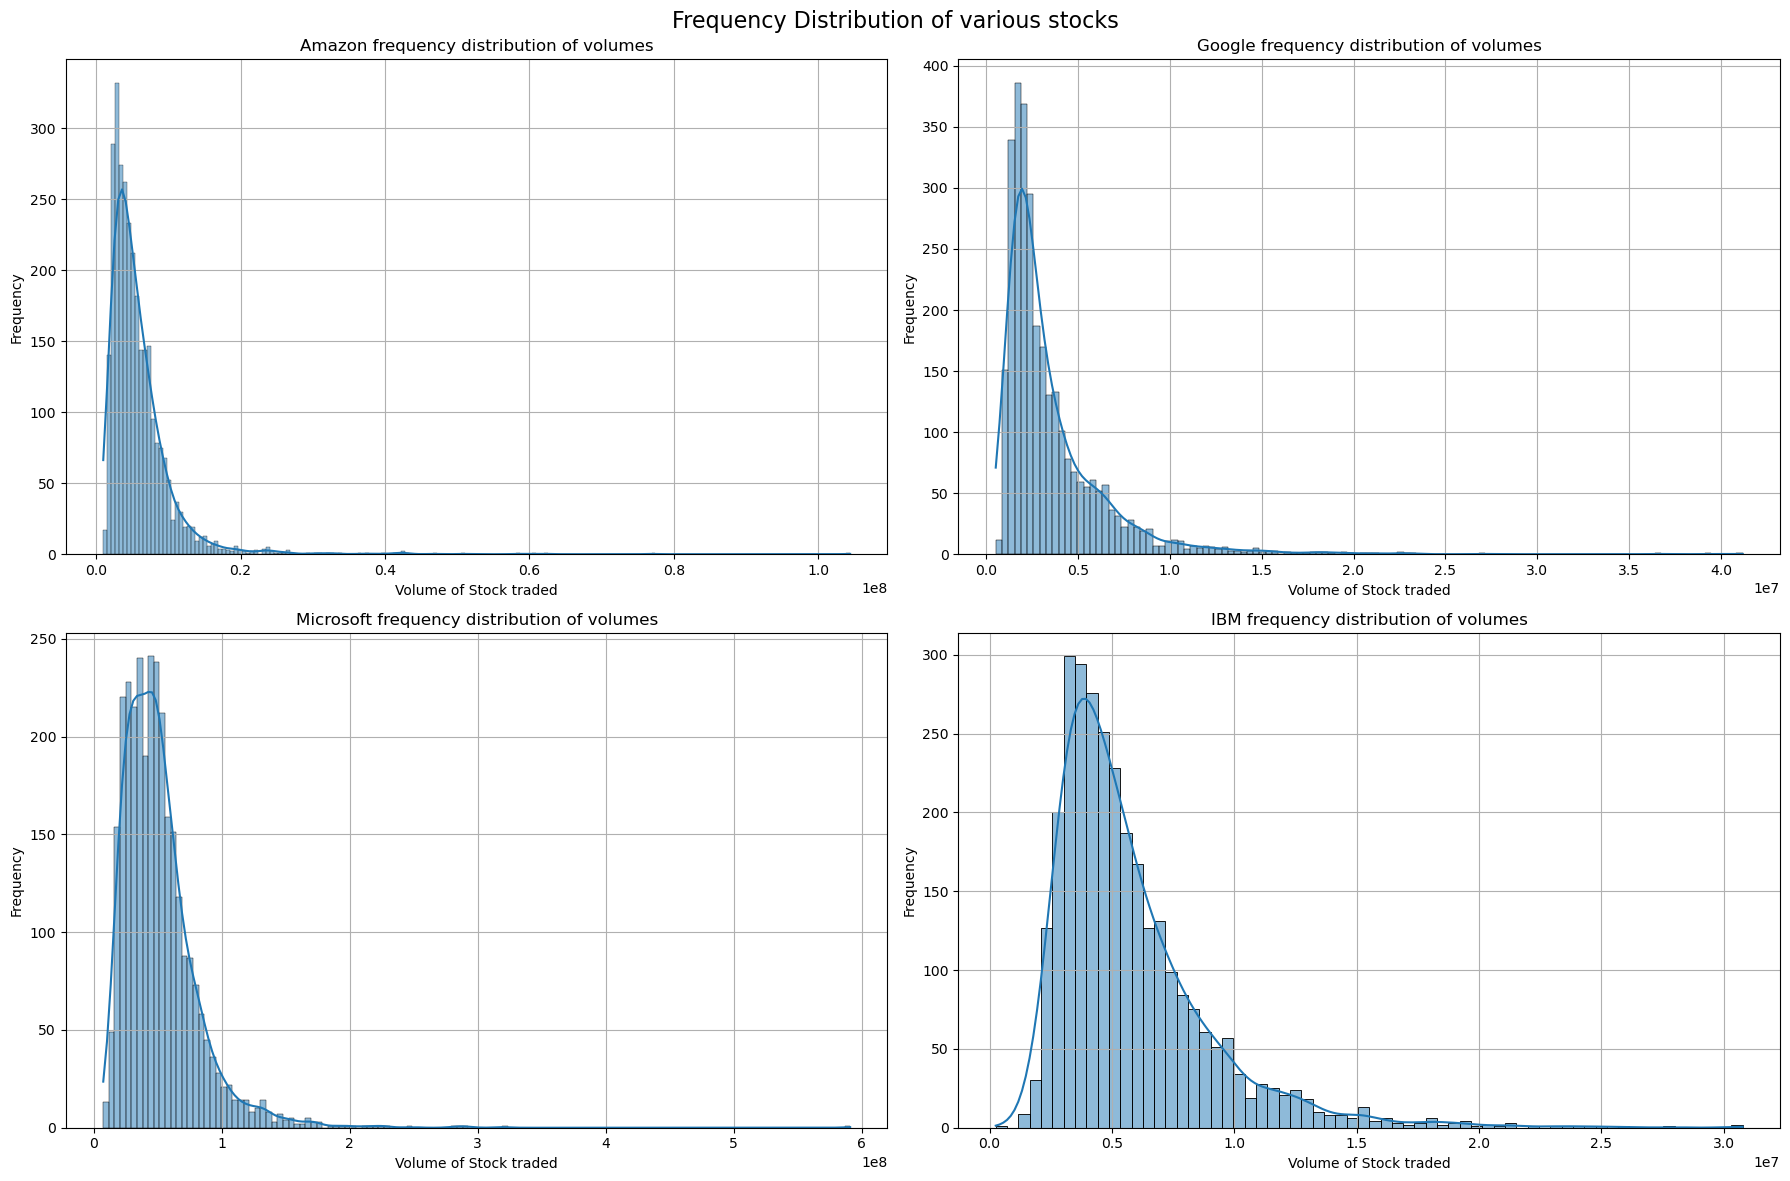

In [22]:
# Frequency distribution of volumes

plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
sns.histplot(combined_df['AMZN_Volume'], kde=True)
plt.xlabel("Volume of Stock traded")
plt.ylabel("Frequency")
plt.title("Amazon frequency distribution of volumes")
plt.grid()

plt.subplot(2,2,2)
sns.histplot(combined_df['GOOGL_Volume'], kde=True)
plt.xlabel("Volume of Stock traded")
plt.ylabel("Frequency")
plt.title("Google frequency distribution of volumes")
plt.grid()

plt.subplot(2,2,3)
sns.histplot(combined_df['MSFT_Volume'], kde=True)
plt.xlabel("Volume of Stock traded")
plt.ylabel("Frequency")
plt.title("Microsoft frequency distribution of volumes")
plt.grid()

plt.subplot(2,2,4)
sns.histplot(combined_df['IBM_Volume'], kde=True)
plt.xlabel("Volume of Stock traded")
plt.ylabel("Frequency")
plt.title("IBM frequency distribution of volumes")
plt.grid()

plt.suptitle("Frequency Distribution of various stocks", fontsize=16)
plt.tight_layout()
plt.show()


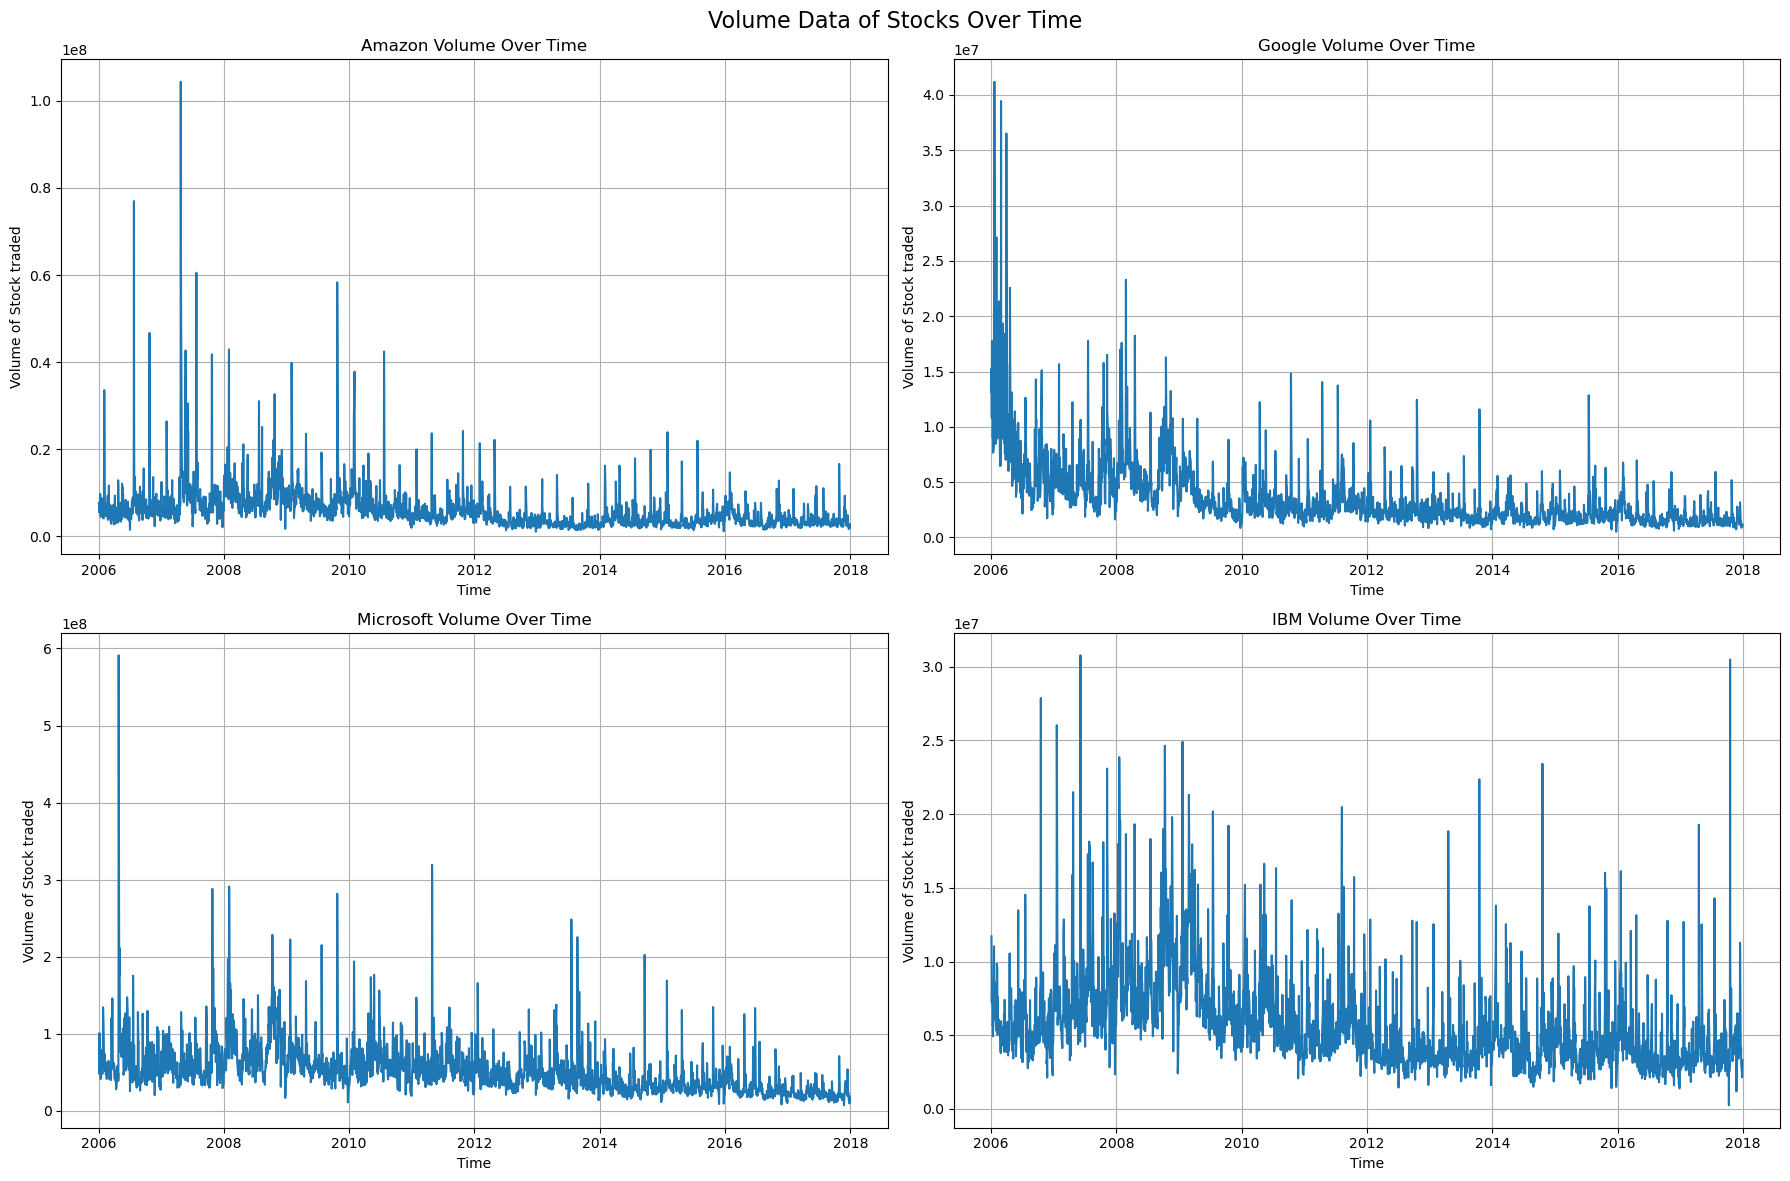

In [24]:
# Stock volume variation over time

plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(combined_df['Date'], combined_df['AMZN_Volume'])
plt.xlabel("Time")
plt.ylabel("Volume of Stock traded")
plt.title("Amazon Volume Over Time")
plt.grid()

plt.subplot(2,2,2)
plt.plot(combined_df['Date'], combined_df['GOOGL_Volume'])
plt.xlabel("Time")
plt.ylabel("Volume of Stock traded")
plt.title("Google Volume Over Time")
plt.grid()

plt.subplot(2,2,3)
plt.plot(combined_df['Date'], combined_df['MSFT_Volume'])
plt.xlabel("Time")
plt.ylabel("Volume of Stock traded")
plt.title("Microsoft Volume Over Time")
plt.grid()

plt.subplot(2,2,4)
plt.plot(combined_df['Date'], combined_df['IBM_Volume'])
plt.xlabel("Time")
plt.ylabel("Volume of Stock traded")
plt.title("IBM Volume Over Time")
plt.grid()

plt.suptitle("Volume Data of Stocks Over Time", fontsize=16)
plt.tight_layout()
plt.show()


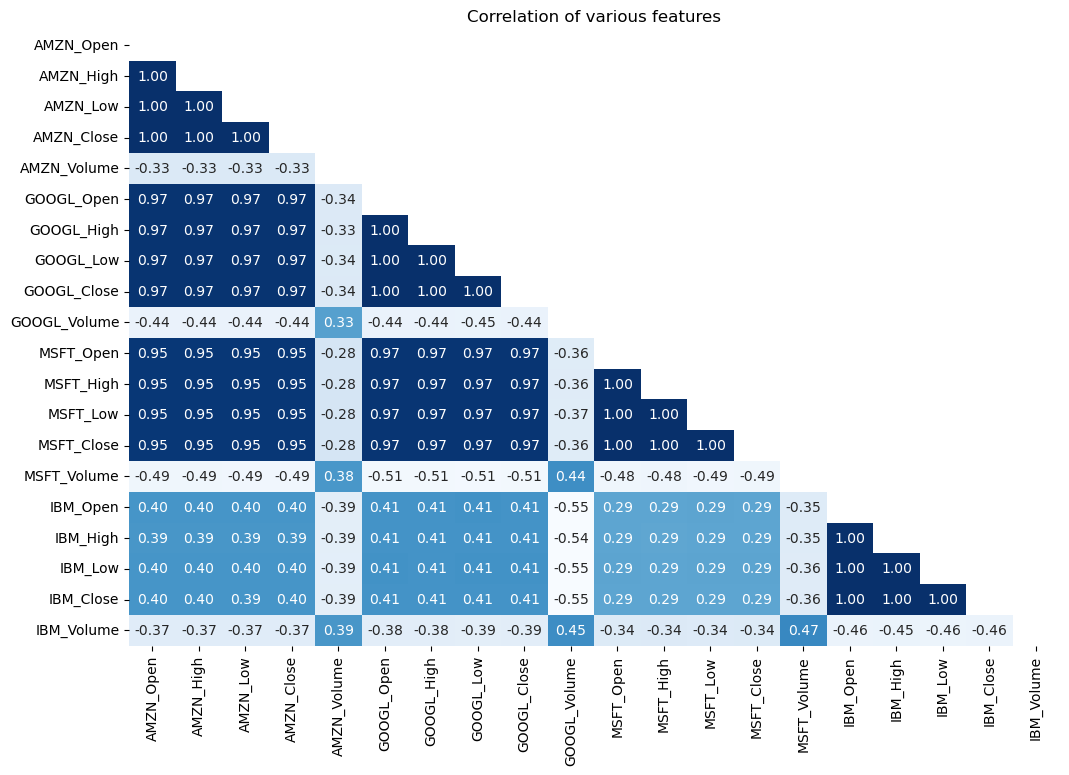

In [27]:
# Analyse correlations

plt.figure(figsize= (12,8))

# Compute correlation matrix
corr = combined_df.select_dtypes(include=['float64', 'int64']).corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap 
sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt=".2f", cbar= False)
plt.title("Correlation of various features")
plt.show()


### **1.3 Data Processing**

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [34]:
# Define a function that divides the data into windows and generates target variable values for each window


def create_windowed_data(df, target_stocks, window_size=60, step_size=1):

    df = df.sort_values('Date').reset_index(drop=True)
    
    feature_cols = []
    target_cols = []
    
    for stock in target_stocks:
        stock_cols = [col for col in df.columns if col.startswith(stock+'_')]
        feature_cols.extend(stock_cols)
        target_cols.append(f"{stock}_Close")
    
    X_windows = []
    y_windows = []
    
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        
        X_window = df.iloc[start:end][feature_cols]  
        y_window = df.iloc[end][target_cols] 
        
        X_windows.append(X_window)
        y_windows.append(y_window)
    
    return X_windows, y_windows


In [36]:
X_windows, y_windows = create_windowed_data(
    combined_df,
    target_stocks=['AMZN'],
    window_size=30,
    step_size=1
)

print("Number of windows:", len(X_windows))
print("First X window:\n", X_windows[0].head())
print("First y window:\n", y_windows[0])


Number of windows: 2988
First X window:
    AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume
0      47.47      47.85     46.25       47.58    7582127.0
1      47.48      47.73     46.69       47.25    7440914.0
2      47.16      48.20     47.11       47.65    5417258.0
3      47.97      48.58     47.32       47.87    6154285.0
4      46.55      47.10     46.40       47.08    8945056.0
First y window:
 AMZN_Close    39.26
Name: 30, dtype: object


In [40]:
# Define a function that scales the windowed data

def scale_windowed_X_y(X_windows, y_windows, feature_range=(0, 1)):
    
    # Initialize scalers
    X_scaler = MinMaxScaler(feature_range=feature_range)
    y_scaler = MinMaxScaler(feature_range=feature_range)
    
    # Identify numeric columns
    numeric_cols = [col for col in X_windows[0].columns if col != 'Date']
    
    # Fit scalers incrementally
    for window in X_windows:
        X_scaler.partial_fit(window[numeric_cols])
    for y in y_windows:
        y_array = np.array(y).reshape(-1, 1)
        y_scaler.partial_fit(y_array)
    
    # Transform X windows
    scaled_X_windows = []
    for window in X_windows:
        scaled_window = window.copy()
        scaled_window[numeric_cols] = X_scaler.transform(window[numeric_cols])
        scaled_X_windows.append(scaled_window)
    
    # Transform y windows
    scaled_y_windows = []
    for y in y_windows:
        y_array = np.array(y).reshape(-1, 1)
        scaled_y = y_scaler.transform(y_array).flatten()
        scaled_y_windows.append(scaled_y)
    
    return scaled_X_windows, scaled_y_windows, X_scaler, y_scaler


Next, define the main function that will call the windowing and scaling helper functions.


In [45]:
# Define a function to create input and output data points from the master DataFrame

def create_scaled_train_val_sets(df, target_stocks, window_size=60, step_size=1, split_ratio=0.8, feature_range=(0, 1)):
    
    # Create windowed data
    X_windows, y_windows = create_windowed_data(
        df=df,
        target_stocks=target_stocks,
        window_size=window_size,
        step_size=step_size)

    # Scale X and y
    scaled_X_windows, scaled_y_windows, X_scaler, y_scaler = scale_windowed_X_y(X_windows, y_windows, feature_range=feature_range)

    # Convert to numpy arrays
    scaled_X_windows = np.array(scaled_X_windows)
    scaled_y_windows = np.array(scaled_y_windows)

    # Split into train and validation sets
    total_windows = len(scaled_X_windows)
    split_index = int(total_windows * split_ratio)

    X_train = scaled_X_windows[:split_index]
    y_train = scaled_y_windows[:split_index]
    X_val = scaled_X_windows[split_index:]
    y_val = scaled_y_windows[split_index:]


    return X_train, y_train, X_val, y_val, X_scaler, y_scaler



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

In [54]:
# Checking for patterns in different sequence lengths

def analyze_window_size(df, target_stocks):
    
    # Plot all selected stocks together
    plt.figure(figsize=(14, 6))
    for stock in target_stocks:
        plt.plot(df['Date'], df[f"{stock}_Close"], label=stock)
    
    plt.title("Stock Close Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Weekly and monthly aggregates for pattern detection (small timeframe like original)
    for stock in target_stocks:
        stock_df = df[['Date', f"{stock}_Close"]].copy()
        
        # Filter only for 2015-2018
        stock_df = stock_df[stock_df['Date'].dt.year > 2014]
        stock_df.set_index('Date', inplace=True)
        
        # Resample to weekly and monthly averages
        weekly_avg = stock_df[f"{stock}_Close"].resample('W').mean()
        monthly_avg = stock_df[f"{stock}_Close"].resample('M').mean()
        
        # Plot daily vs weekly vs monthly averages
        plt.figure(figsize=(14, 5))
        plt.plot(stock_df.index, stock_df[f"{stock}_Close"], alpha=0.4, label='Daily')
        plt.plot(weekly_avg.index, weekly_avg.values, label='Weekly Avg', color='orange')
        plt.plot(monthly_avg.index, monthly_avg.values, label='Monthly Avg', color='green')
        plt.title(f"{stock} - Daily vs Weekly vs Monthly Close Prices (2015-2017)")
        plt.legend()
        plt.grid(True)
        plt.show()


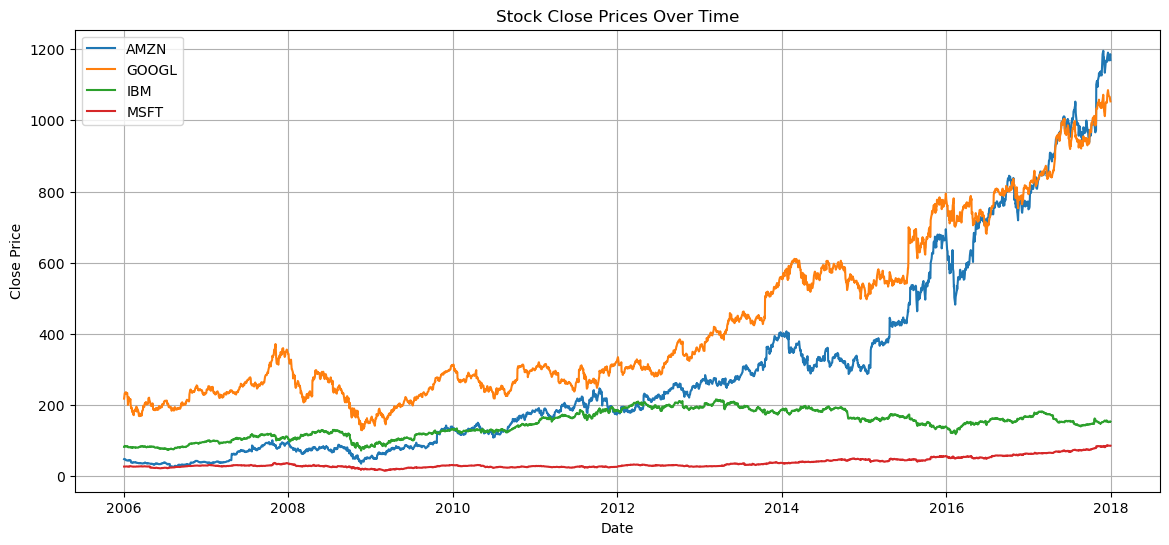

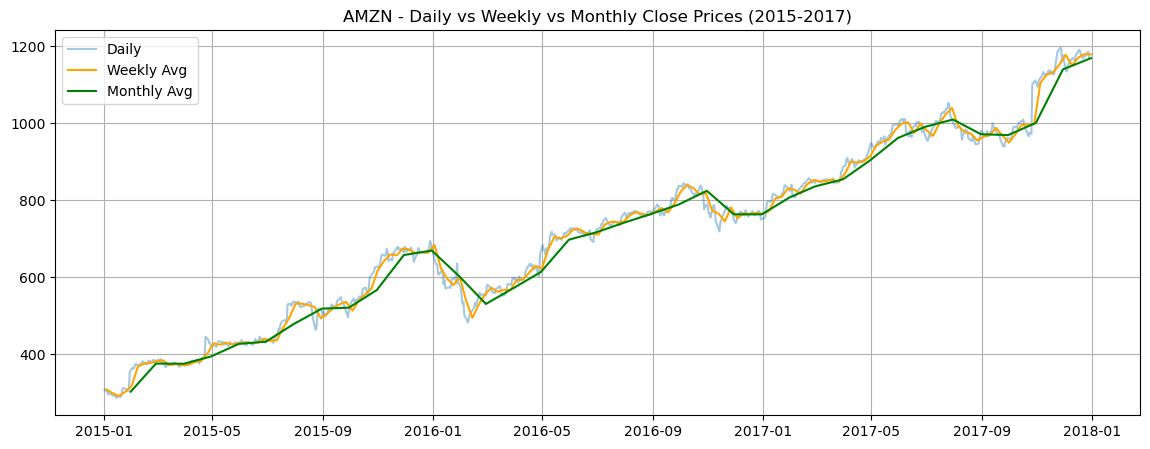

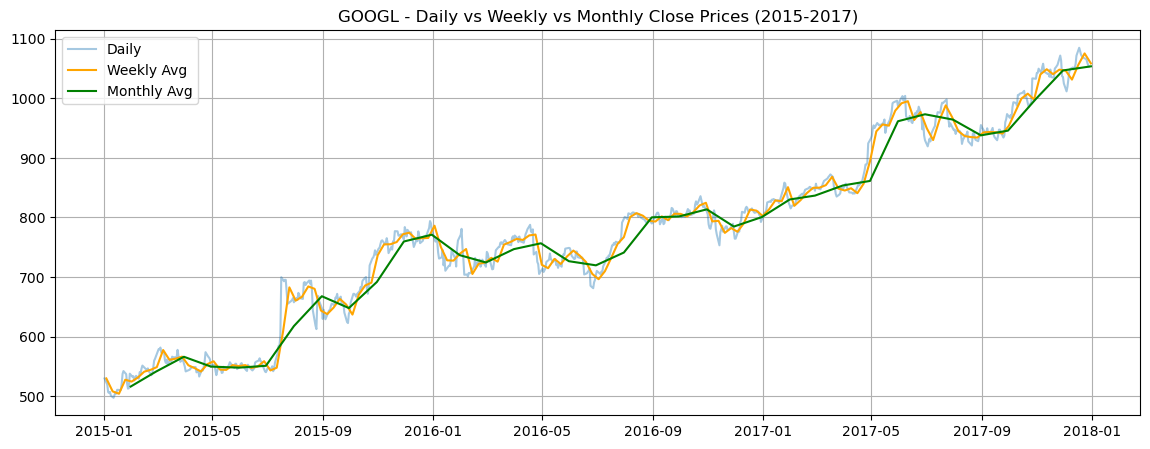

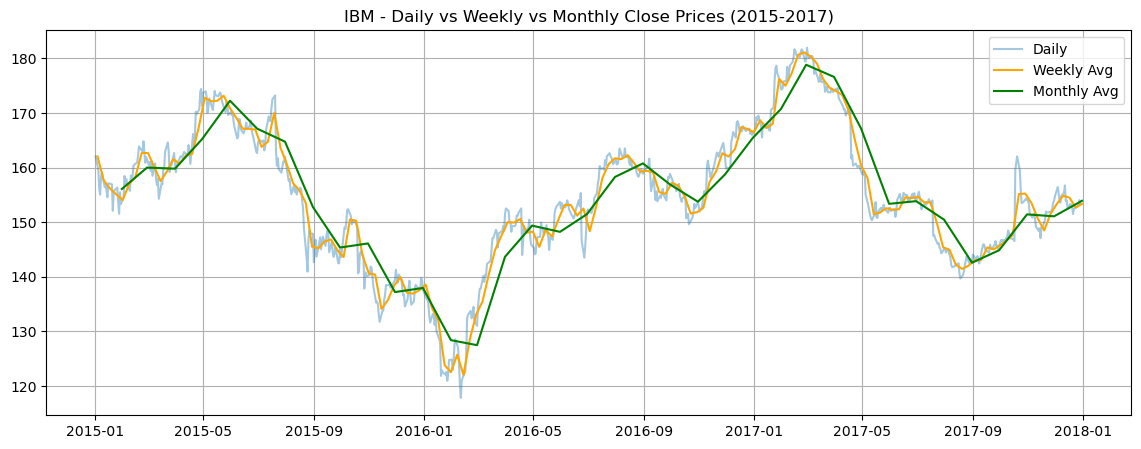

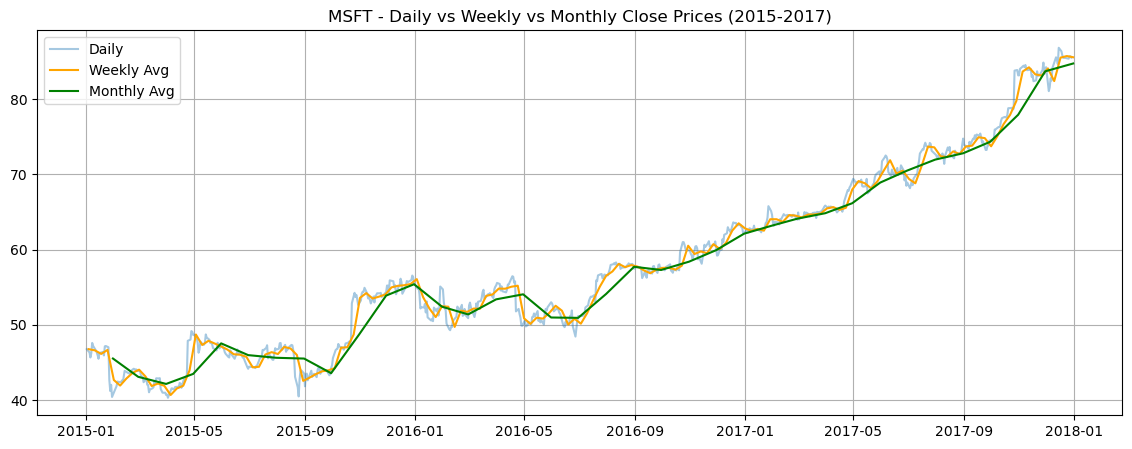

In [56]:
analyze_window_size(combined_df, target_stocks=['AMZN', 'GOOGL', 'IBM', 'MSFT'])

In [58]:
# Create data instances from the master data frame using decided window size and window stride

# Parameters
target_stocks = ['GOOGL']  
window_size = 22                    
step_size = 1                       
split_ratio = 0.8                   

# Create train/validation sets using the combined function
X_train, y_train, X_val, y_val, X_scaler, y_scaler = create_scaled_train_val_sets(
    df=combined_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    split_ratio=split_ratio
)


In [60]:
# Check the number of data points generated

print(f"Train windows: {len(X_train)}")
print(f"Validation windows: {len(X_val)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Train windows: 2396
Validation windows: 600
X_train shape: (2396, 22, 5)
y_train shape: (2396, 1)
X_val shape: (600, 22, 5)
y_val shape: (600, 1)


In [63]:
# Check if the datasets are compatible inputs to neural networks

def check_rnn_compatibility(X_train, y_train, X_val, y_val):
    print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
    print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")

    if X_train.ndim == 3 and X_val.ndim == 3:
        print("X shapes are correct (samples, timesteps, features).")
    else:
        print("X shape error.")

    if y_train.ndim == 2 and y_val.ndim == 2:
        print("y shapes are correct (samples, 1).")
    else:
        print("y shape error.")

    if not (pd.isnull(X_train).any() or pd.isnull(X_val).any() or 
            pd.isnull(y_train).any() or pd.isnull(y_val).any()):
        print("No missing values.")
    else:
        print("Missing values found.")



In [65]:
check_rnn_compatibility(X_train, y_train, X_val, y_val)


X_train: (2396, 22, 5), X_val: (600, 22, 5)
y_train: (2396, 1), y_val: (600, 1)
X shapes are correct (samples, timesteps, features).
y shapes are correct (samples, 1).
No missing values.


## **2 RNN Models**

### **2.1 Simple RNN Model**

In [71]:
# Create a function that creates a simple RNN model according to the model configuration arguments


def build_rnn_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    
    # RNN Layer
    model.add(SimpleRNN(units, activation='tanh', input_shape=input_shape, return_sequences=False))
    
    # Dropout Layer
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(1))  # For regression
    
    # Compile Model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [74]:
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")


X_train shape: (2396, 22, 5), dtype: float32
y_train shape: (2396, 1), dtype: float32


In [76]:
# Find an optimal configuration of simple RNN

def tune_rnn_hyperparameters(X_train, y_train, X_val, y_val, input_shape, epochs=10):
    
    units_list = [32, 64, 128]
    dropout_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.001]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    for units in units_list:
        for dropout in dropout_list:
            for lr in lr_list:
                print(f"Training with units={units}, dropout={dropout}, lr={lr}")
                
                model = build_rnn_model(input_shape, units, dropout, lr)
                
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                )

                val_loss = min(history.history['val_loss'])
                print(f"Val Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

    print(f"\nBest Hyperparameters: {best_params}, Best Val Loss: {best_val_loss}")
    return best_model, best_params



In [78]:
# Find the best configuration based on evaluation metrics

best_model, best_params = tune_rnn_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    epochs=20
)

Training with units=32, dropout=0.1, lr=0.01
Val Loss: 0.0006596031598746777
Training with units=32, dropout=0.1, lr=0.001
Val Loss: 0.0003484404878690839
Training with units=32, dropout=0.2, lr=0.01
Val Loss: 0.00017642231250647455
Training with units=32, dropout=0.2, lr=0.001
Val Loss: 0.0004146082210354507
Training with units=32, dropout=0.3, lr=0.01
Val Loss: 0.0002152653323719278
Training with units=32, dropout=0.3, lr=0.001
Val Loss: 0.00016623295960016549
Training with units=64, dropout=0.1, lr=0.01
Val Loss: 0.00019278243416920304
Training with units=64, dropout=0.1, lr=0.001
Val Loss: 0.000656277232337743
Training with units=64, dropout=0.2, lr=0.01
Val Loss: 0.00023852978483773768
Training with units=64, dropout=0.2, lr=0.001
Val Loss: 0.00031861383467912674
Training with units=64, dropout=0.3, lr=0.01
Val Loss: 0.00015228410484269261
Training with units=64, dropout=0.3, lr=0.001
Val Loss: 0.0006583812646567822
Training with units=128, dropout=0.1, lr=0.01
Val Loss: 0.0719258

In [80]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


# Best hyperparameters from tuning
best_units = 64
best_dropout = 0.3
best_lr = 0.01


# Build the model
final_rnn_model = build_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_units,
    dropout_rate=best_dropout,
    learning_rate=best_lr
)


# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)


history = final_rnn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data= (X_val, y_val),
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on validation data (optional, if separate test not available)
val_loss, val_mae = final_rnn_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")


Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1249 - mae: 0.2338 - val_loss: 0.0074 - val_mae: 0.0785 - learning_rate: 0.0100
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0328 - val_loss: 0.0012 - val_mae: 0.0282 - learning_rate: 0.0100
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0029 - val_mae: 0.0510 - learning_rate: 0.0100
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7966e-04 - mae: 0.0213 - val_loss: 9.9770e-04 - val_mae: 0.0276 - learning_rate: 0.0100
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6974e-04 - mae: 0.0188 - val_loss: 0.0022 - val_mae: 0.0442 - learning_rate: 0.0100
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2361e-04 - mae: 0.0193 - val_loss: 2.8320e-04 - val_mae: 0.0133 - learning_rate: 0.0100
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5027e-04 - mae: 0.0170 - val_loss: 3.7264e-04 - val_mae: 0.0160 - learni

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


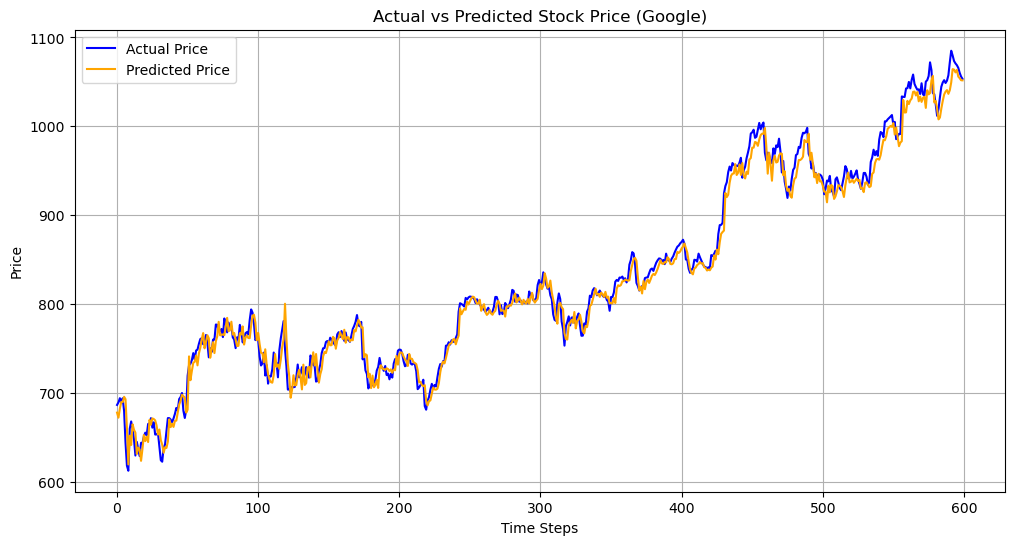

In [87]:
# Predict on the test data and plot

y_pred_scaled = final_rnn_model.predict(X_val)

# Inverse transform predictions and actual values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_val)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Stock Price (Google)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [90]:
# Compute the performance of the model on the testing data set

# Compute metrics
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Model Performance on Validation/Test Set:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance on Validation/Test Set:
MSE: 164.9301
RMSE: 12.8425
MAE: 9.9663
R² Score: 0.9870


### **2.2 LSTM Model** 

In [95]:
# Define a function to create a model and specify default values for hyperparameters

def build_lstm_model(input_shape, units=50, dropout=0.2, learning_rate=0.001):
    
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))  
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [98]:
# Find an optimal configuration

def tune_lstm_hyperparameters(X_train, y_train, X_val, y_val, input_shape, epochs=20):
    
    units_list = [32, 64, 128]
    dropout_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.001]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    for units in units_list:
        for dropout in dropout_list:
            for lr in lr_list:
                print(f"Training with units={units}, dropout={dropout}, lr={lr}")
                
                model = build_lstm_model(input_shape, units, dropout, lr)
                
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                )

                val_loss = min(history.history['val_loss'])
                print(f"Val Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

    print(f"\nBest Hyperparameters: {best_params}, Best Val Loss: {best_val_loss}")
    return best_model, best_params


In [100]:
best_lstm_model, best_lstm_params = tune_lstm_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    epochs=20
)


Training with units=32, dropout=0.1, lr=0.01
Val Loss: 0.00022100516071077436
Training with units=32, dropout=0.1, lr=0.001
Val Loss: 0.0002536019019316882
Training with units=32, dropout=0.2, lr=0.01
Val Loss: 0.00025084501248784363
Training with units=32, dropout=0.2, lr=0.001
Val Loss: 0.00024565248168073595
Training with units=32, dropout=0.3, lr=0.01
Val Loss: 0.0006282093236222863
Training with units=32, dropout=0.3, lr=0.001
Val Loss: 0.000289739080471918
Training with units=64, dropout=0.1, lr=0.01
Val Loss: 0.00022564645041711628
Training with units=64, dropout=0.1, lr=0.001
Val Loss: 0.0002570405777078122
Training with units=64, dropout=0.2, lr=0.01
Val Loss: 0.00020853882597293705
Training with units=64, dropout=0.2, lr=0.001
Val Loss: 0.0006442724843509495
Training with units=64, dropout=0.3, lr=0.01
Val Loss: 0.00027423157007433474
Training with units=64, dropout=0.3, lr=0.001
Val Loss: 0.0002686995721887797
Training with units=128, dropout=0.1, lr=0.01
Val Loss: 0.0003164

In [103]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameters from tuning
best_units = 128
best_dropout = 0.2
best_lr = 0.01


# Build the model
final_lstm_model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_units,
    dropout= best_dropout,
    learning_rate=best_lr
)


# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)


history = final_lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data= (X_val, y_val),
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on validation data (optional, if separate test not available)
val_loss, val_mae = final_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")


Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0330 - mae: 0.0948 - val_loss: 0.0015 - val_mae: 0.0329 - learning_rate: 0.0100
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6973e-04 - mae: 0.0155 - val_loss: 5.4572e-04 - val_mae: 0.0188 - learning_rate: 0.0100
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2990e-04 - mae: 0.0129 - val_loss: 4.4575e-04 - val_mae: 0.0172 - learning_rate: 0.0100
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.9502e-04 - mae: 0.0124 - val_loss: 2.4066e-04 - val_mae: 0.0118 - learning_rate: 0.0100
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8055e-04 - mae: 0.0119 - val_loss: 2.3418e-04 - val_mae: 0.0116 - learning_rate: 0.0100
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4484e-04 - mae: 0.0114 - val_loss: 3.1342e-04 - val_mae: 0.0137 - learning_rate: 0.0100
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.0827e-04 - mae: 0.0103 - val_loss: 9.5574e-04 

In [115]:
# Compute the performance of the model on the testing data set

y_pred = final_lstm_model.predict(X_val)

# Inverse transform both actual and predicted values
y_val_inv = y_scaler.inverse_transform(y_val)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# Compute metrics on original scale
mse = mean_squared_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_inv, y_pred_inv)
r2 = r2_score(y_val_inv, y_pred_inv)

# Print performance
print("Model Performance on Validation/Test Set:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Model Performance on Validation/Test Set:
MSE: 214.1290
RMSE: 14.6331
MAE: 11.0863
R² Score: 0.9831


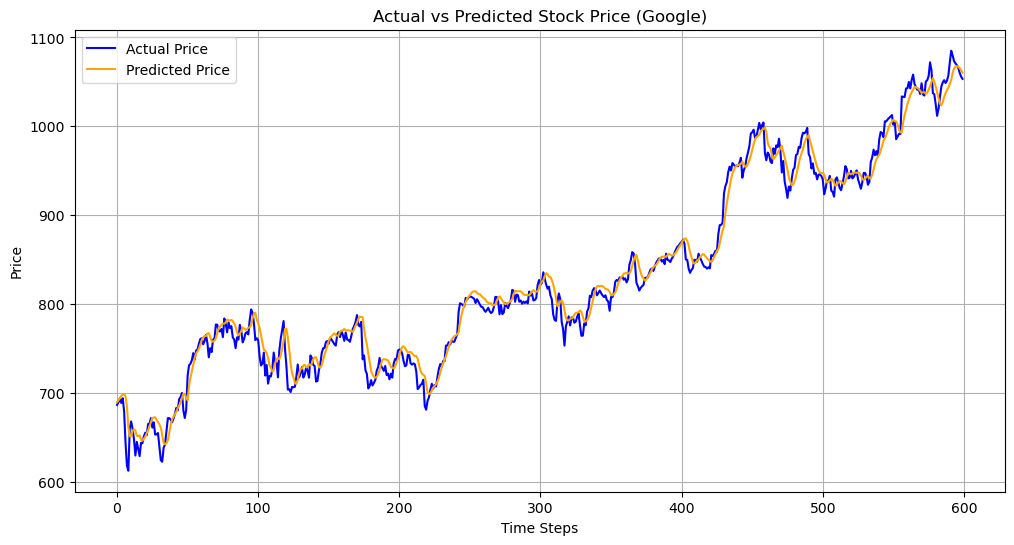

In [120]:
# Predict on the test data

# Ensure correct shape for inverse transform
y_val_reshaped = y_val.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform to original scale
y_val_inverse = y_scaler.inverse_transform(y_val_reshaped)
y_pred_inverse = y_scaler.inverse_transform(y_pred_reshaped)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse, label='Actual Price', color='blue')
plt.plot(y_pred_inverse, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Stock Price (Google)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



## **3 Predicting Multiple Target Variables** 

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

In [127]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

# Parameters
target_stocks = ['AMZN', 'GOOGL', 'MSFT', 'IBM']  
window_size = 22                    
step_size = 1                       
split_ratio = 0.8                   

# Create train/validation sets using the combined function
X_train, y_train, X_val, y_val, X_scaler, y_scaler = create_scaled_train_val_sets(
    df=combined_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    split_ratio=split_ratio
)


In [129]:
# Check the number of data points generated

print(f"Train windows: {len(X_train)}")
print(f"Validation windows: {len(X_val)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Train windows: 2396
Validation windows: 600
X_train shape: (2396, 22, 20)
y_train shape: (2396, 4)
X_val shape: (600, 22, 20)
y_val shape: (600, 4)


### **3.2 Run RNN Models**

In [194]:
# Find an optimal configuration of simple RNN

def build_rnn_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    
    # RNN Layer
    model.add(SimpleRNN(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units, activation='tanh', return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(4))  # For regression
    
    # Compile Model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [196]:
# Find the best configuration

def tune_rnn_hyperparameters(X_train, y_train, X_val, y_val, input_shape, epochs=10):
    
    units_list = [32, 64, 128]
    dropout_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.001]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    for units in units_list:
        for dropout in dropout_list:
            for lr in lr_list:
                print(f"Training with units={units}, dropout={dropout}, lr={lr}")
                
                model = build_rnn_model(input_shape, units, dropout, lr)
                
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                )

                val_loss = min(history.history['val_loss'])
                print(f"Val Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

    print(f"\nBest Hyperparameters: {best_params}, Best Val Loss: {best_val_loss}")
    return best_model, best_params


In [198]:
best_model, best_params = tune_rnn_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    epochs=20
)

Training with units=32, dropout=0.1, lr=0.01
Val Loss: 0.0011917155934497714
Training with units=32, dropout=0.1, lr=0.001
Val Loss: 0.01233349647372961
Training with units=32, dropout=0.2, lr=0.01
Val Loss: 0.0034743512514978647
Training with units=32, dropout=0.2, lr=0.001
Val Loss: 0.006265955977141857
Training with units=32, dropout=0.3, lr=0.01
Val Loss: 0.008093669079244137
Training with units=32, dropout=0.3, lr=0.001
Val Loss: 0.011695187538862228
Training with units=64, dropout=0.1, lr=0.01
Val Loss: 0.0036299920175224543
Training with units=64, dropout=0.1, lr=0.001
Val Loss: 0.0024382739793509245
Training with units=64, dropout=0.2, lr=0.01
Val Loss: 0.02011917345225811
Training with units=64, dropout=0.2, lr=0.001
Val Loss: 0.009209602139890194
Training with units=64, dropout=0.3, lr=0.01
Val Loss: 0.0321870818734169
Training with units=64, dropout=0.3, lr=0.001
Val Loss: 0.0029789393302053213
Training with units=128, dropout=0.1, lr=0.01
Val Loss: 0.032426368445158005
Trai

In [200]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

# Best hyperparameters from tuning
best_units = 32
best_dropout = 0.1
best_lr = 0.01


# Build the model
final_rnn_model = build_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_units,
    dropout_rate=best_dropout,
    learning_rate=best_lr
)


# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)


history = final_rnn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data= (X_val, y_val),
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on validation data
val_loss, val_mae = final_rnn_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")


Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - loss: 0.1417 - mae: 0.2608 - val_loss: 0.0167 - val_mae: 0.0957 - learning_rate: 0.0100
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038 - mae: 0.0463 - val_loss: 0.0078 - val_mae: 0.0602 - learning_rate: 0.0100
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mae: 0.0299 - val_loss: 0.0055 - val_mae: 0.0534 - learning_rate: 0.0100
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0059 - val_mae: 0.0496 - learning_rate: 0.0100
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8641e-04 - mae: 0.0207 - val_loss: 0.0038 - val_mae: 0.0422 - learning_rate: 0.0100
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5506e-04 - mae: 0.0187 - val_loss: 0.0033 - val_mae: 0.0359 - learning_rate: 0.0100
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9722e-04 - mae: 0.0161 - val_loss: 0.0039 - val_mae: 0.0407 - learning_rate: 0.01

In [202]:
# Compute the performance of the model on the testing data set

# Predict
y_pred = final_rnn_model.predict(X_val)

# Inverse transform (if needed)
y_val_inv = y_scaler.inverse_transform(y_val)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# Initialize metrics dict
metrics = {}

for i, stock in enumerate(target_stocks):
    mse = mean_squared_error(y_val_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_val_inv[:, i], y_pred_inv[:, i])
    
    metrics[stock] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

# Print results
print("\nModel Performance on Validation/Test Set:")
for stock, vals in metrics.items():
    print(f"\n{stock}:")
    for metric, value in vals.items():
        print(f"{metric}: {value:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Model Performance on Validation/Test Set:

AMZN:
MSE: 1660.7051
RMSE: 40.7517
MAE: 31.7213
R²: 0.9484

GOOGL:
MSE: 506.7715
RMSE: 22.5116
MAE: 16.3236
R²: 0.9599

MSFT:
MSE: 4.2064
RMSE: 2.0509
MAE: 1.5661
R²: 0.9637

IBM:
MSE: 43.2776
RMSE: 6.5786
MAE: 5.9356
R²: 0.7169


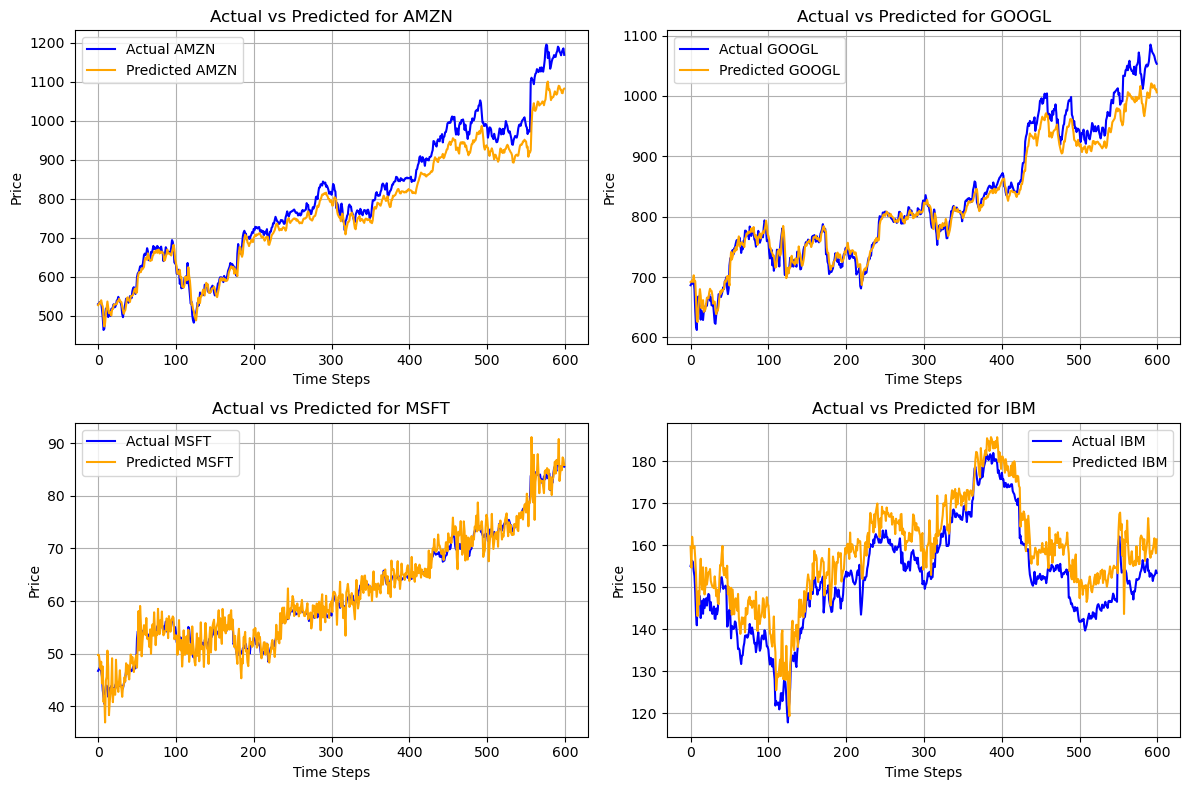

In [204]:
# Plotting the actual vs predicted values for all targets

# Inverse transform predictions and actual values
y_val_inv = y_scaler.inverse_transform(y_val)        # Shape: (samples, num_targets)
y_pred_inv = y_scaler.inverse_transform(y_pred)      # Shape: (samples, num_targets)

# Define target stocks dynamically
target_stocks = ['AMZN', 'GOOGL', 'MSFT', 'IBM']  # Adjust as needed

# Calculate number of rows (2 subplots per row)
num_stocks = len(target_stocks)
cols = 2
rows = math.ceil(num_stocks / cols)

# Create subplots
plt.figure(figsize=(12, rows * 4))

for i, stock in enumerate(target_stocks):
    plt.subplot(rows, cols, i + 1)
    plt.plot(y_val_inv[:, i], label=f'Actual {stock}', color='blue')
    plt.plot(y_pred_inv[:, i], label=f'Predicted {stock}', color='orange')
    plt.title(f'Actual vs Predicted for {stock}')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [170]:
# Find an optimal configuration of advanced RNN

def build_lstm_model(input_shape, units=50, dropout=0.2, learning_rate=0.001):
    
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, activation='tanh', return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(4))  
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [172]:
# Find the best configuration

def tune_lstm_hyperparameters(X_train, y_train, X_val, y_val, input_shape, epochs=20):
    
    units_list = [32, 64, 128]
    dropout_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.001]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    for units in units_list:
        for dropout in dropout_list:
            for lr in lr_list:
                print(f"Training with units={units}, dropout={dropout}, lr={lr}")
                
                model = build_lstm_model(input_shape, units, dropout, lr)
                
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                )

                val_loss = min(history.history['val_loss'])
                print(f"Val Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

    print(f"\nBest Hyperparameters: {best_params}, Best Val Loss: {best_val_loss}")
    return best_model, best_params


In [174]:
best_lstm_model, best_lstm_params = tune_lstm_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    epochs=20
)

Training with units=32, dropout=0.1, lr=0.01
Val Loss: 0.0028073429130017757
Training with units=32, dropout=0.1, lr=0.001
Val Loss: 0.0012745135463774204
Training with units=32, dropout=0.2, lr=0.01
Val Loss: 0.0013824044726788998
Training with units=32, dropout=0.2, lr=0.001
Val Loss: 0.0012960274470970035
Training with units=32, dropout=0.3, lr=0.01
Val Loss: 0.0010642234701663256
Training with units=32, dropout=0.3, lr=0.001
Val Loss: 0.0008310143020935357
Training with units=64, dropout=0.1, lr=0.01
Val Loss: 0.0015280161751434207
Training with units=64, dropout=0.1, lr=0.001
Val Loss: 0.0005302205681800842
Training with units=64, dropout=0.2, lr=0.01
Val Loss: 0.0004277456901036203
Training with units=64, dropout=0.2, lr=0.001
Val Loss: 0.0003590607666410506
Training with units=64, dropout=0.3, lr=0.01
Val Loss: 0.0010749440407380462
Training with units=64, dropout=0.3, lr=0.001
Val Loss: 0.00041373621206730604
Training with units=128, dropout=0.1, lr=0.01
Val Loss: 0.10515014827

In [176]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameters from tuning
best_units = 128
best_dropout = 0.2
best_lr = 0.001


# Build the model
final_lstm_model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_units,
    dropout= best_dropout,
    learning_rate=best_lr
)


# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)


history = final_lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data= (X_val, y_val),
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on validation data (optional, if separate test not available)
val_loss, val_mae = final_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")


Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0048 - mae: 0.0431 - val_loss: 0.0044 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.5848e-04 - mae: 0.0174 - val_loss: 0.0020 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.9387e-04 - mae: 0.0146 - val_loss: 0.0017 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.5647e-04 - mae: 0.0137 - val_loss: 0.0012 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.2513e-04 - mae: 0.0128 - val_loss: 0.0019 - val_mae: 0.0335 - learning_rate: 0.0010
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.7518e-04 - mae: 0.0117 - val_loss: 4.0729e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.5634e-04 - mae: 0.0114 - val_loss: 0.0013 - val_mae: 0.0253 - 

In [178]:
# Compute the performance of the model on the testing data set

# Predict
y_pred = final_lstm_model.predict(X_val)

# Inverse transform (if needed)
y_val_inv = y_scaler.inverse_transform(y_val)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# Initialize metrics dict
metrics = {}

for i, stock in enumerate(target_stocks):
    mse = mean_squared_error(y_val_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_val_inv[:, i], y_pred_inv[:, i])
    
    metrics[stock] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

# Print results
print("\nModel Performance on Validation/Test Set:")
for stock, vals in metrics.items():
    print(f"\n{stock}:")
    for metric, value in vals.items():
        print(f"{metric}: {value:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Model Performance on Validation/Test Set:

AMZN:
MSE: 643.1682
RMSE: 25.3608
MAE: 18.3762
R²: 0.9800

GOOGL:
MSE: 447.1829
RMSE: 21.1467
MAE: 16.2401
R²: 0.9646

MSFT:
MSE: 8.7400
RMSE: 2.9563
MAE: 2.5387
R²: 0.9246

IBM:
MSE: 12.9294
RMSE: 3.5957
MAE: 2.7132
R²: 0.9154


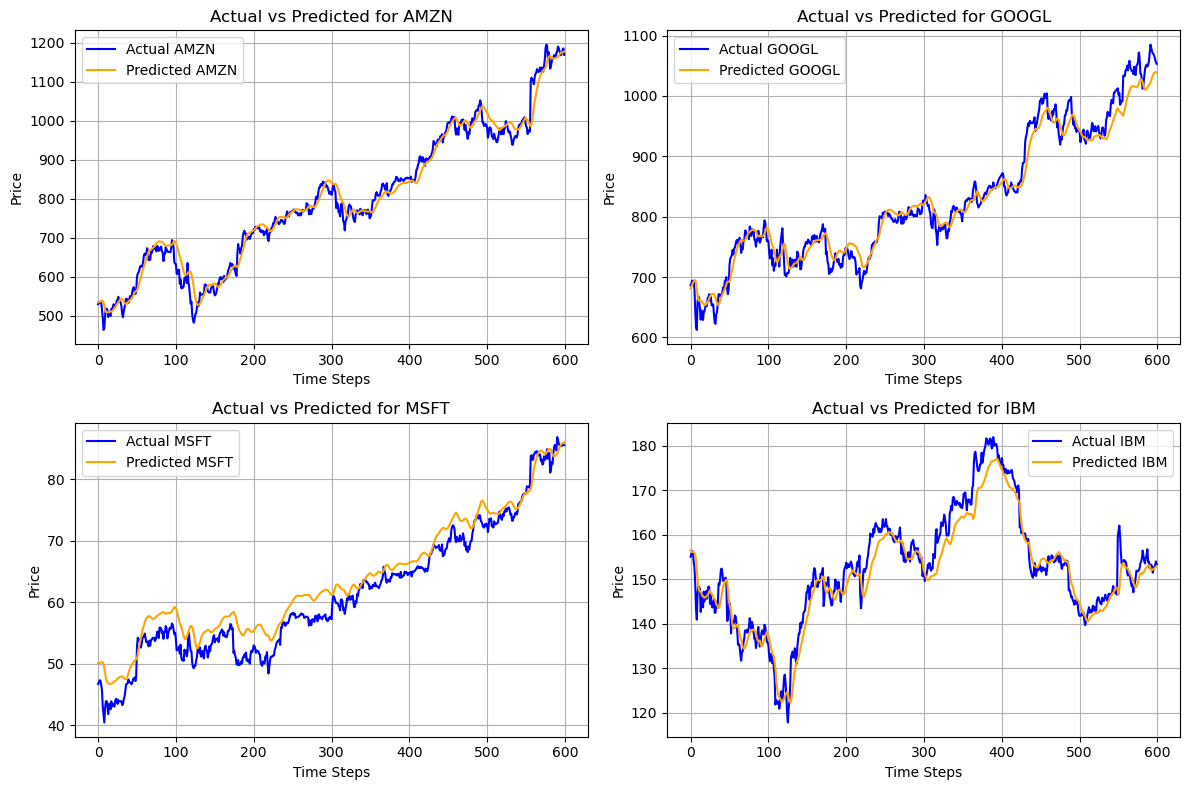

In [180]:
# Plotting the actual vs predicted values for all targets


# Inverse transform predictions and actual values
y_val_inv = y_scaler.inverse_transform(y_val)        
y_pred_inv = y_scaler.inverse_transform(y_pred)      

# Define target stocks dynamically
target_stocks = ['AMZN', 'GOOGL', 'MSFT', 'IBM']  

# Calculate number of rows (2 subplots per row)
num_stocks = len(target_stocks)
cols = 2
rows = math.ceil(num_stocks / cols)

# Create subplots
plt.figure(figsize=(12, rows * 4))

for i, stock in enumerate(target_stocks):
    plt.subplot(rows, cols, i + 1)
    plt.plot(y_val_inv[:, i], label=f'Actual {stock}', color='blue')
    plt.plot(y_pred_inv[:, i], label=f'Predicted {stock}', color='orange')
    plt.title(f'Actual vs Predicted for {stock}')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


##  **Final Insights & Outcomes**

### **1. Data Preparation**
- Combined stock data from multiple companies into a single master DataFrame.
- Created **windowed sequences** (sliding windows) for time-series modeling.
- Applied **MinMaxScaler** for normalization to improve training stability.
- Chose a **window size of 22** (approx. monthly trading days) for capturing short-term trends.

---

### **2. Model Development**
- **Baseline: Simple RNN**
  - Hyperparameter tuning for `units`, `dropout`, `learning_rate`.
  - **Best parameters**:
    - `units = 64`, `dropout = 0.3`, `learning_rate = 0.01`
  - Achieved **Val Loss ≈ 0.00015**, but showed limitations in long-term dependency handling.

- **Advanced Model: LSTM**
  - Implemented **LSTM** with dropout and tuned hyperparameters.
  - **Hyperparameter search space**:
    - `units`: [32, 64, 128]
    - `dropout`: [0.1, 0.2, 0.3]
    - `learning_rate`: [0.01, 0.001]
  - **Best configuration**:
    - `units = 128`, `dropout = 0.2`, `learning_rate = 0.01`
  - Used **EarlyStopping** and **ReduceLROnPlateau** for regularization and adaptive learning.

---

### **3. Model Evaluation (Single Stock: GOOGL)**
- **Simple RNN**:
  - R² Score: **0.9870**  
- **LSTM**:
  - R² Score: **0.9831**  

**Observations**:
- **Simple RNN achieved the highest R² for GOOGL (0.9870)**, indicating better predictive performance compared to LSTM for this single-stock scenario.
- LSTM still performed well but had slightly lower variance explanation (~98.3%). A difference of 0.4%

---

### **4. Multi-Stock Prediction (GOOGL, AMZN, MSFT, IBM using LSTM)**
- **AMZN**: R² = **0.9800**  
- **GOOGL**: R² = **0.9646**  
- **MSFT**: R² = **0.9246**  
- **IBM**: R² = **0.9154**  

**Observations**:
- **AMZN had the highest R² among multi-stock predictions (0.9800)**.
- **IBM showed the weakest R² (0.9154)**, which is still very good but comparitively weaker
- **AMZN and GOOGL maintained strong R² (>0.96)**, confirming LSTM’s ability to generalize well for large-cap stocks.

---

### **5. Key Insights**
- R² comparison clearly shows:
  - For **single stock**, **Simple RNN > LSTM** (0.9870 vs 0.9831).
  - For **multi-stock**, **LSTM performs best on AMZN and GOOGL** and reasonably well on IBM and MSFT.
- **IBM remains a challenge**, possibly due to lower volatility or different price dynamics.

---

### **6. Final Outcome**
- **Single-Stock Scenario (GOOGL)**:
  - **Simple RNN achieved the best R² (0.9870)**, slightly outperforming LSTM (0.9831).
- **Multi-Stock Scenario (LSTM)**:
  - **AMZN performed best (R² = 0.9800)**, followed by GOOGL (0.9646) and MSFT (0.9246).
  - **IBM lagged slightly (R² = 0.9154)**, suggesting the need for model customization per stock.
- Overall:
  - Models are **highly effective for high-R² stocks (MSFT, GOOGL, AMZN)**.
  - Future improvements should focus on **stock-specific modeling** or **adaptive architectures** for weaker stocks like IBM.


